# Dave's FAA Aircraft Characteristics Data practice data science project
---
## Objectives
### Meta (why I'm doing this at all)
* Show off some data science skills on a project with public sources without NDA/IP issues
* Demonstrate ability to do self-guided data science work
* Demonstrate step-by-step thinking and documentation
### Project (the goals of the data science here)
* Develop models that can "fill in the blank" and predict aircraft attributes if others are known
* Predict flight attributes from stationary features
* Predict manufacturer
* Predict # of IFR operations
---
## Outline 
#### Exploratory data analysis and data cleaning
* Understand contents of the database
* Make decisions about missing and bad data
* explore potential features and targets for models
* explore statistical properties of numerical variables
* select and perform transforms on features 
---
## Data Source
https://www.faa.gov/airports/engineering/aircraft_char_database/data

## **Offline pre-processing**
* Renamed .xlsx file to FAA.csv
---
## **Load data and assess contents**

In [187]:
# all the imports for the project
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [188]:
# import xlsx file
df = pd.read_excel('FAA.xlsx',sheet_name='ACD_Data')

# summaraize dataframe structure and contents 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ICAO_Code                               387 non-null    object 
 1   FAA_Designator                          387 non-null    object 
 2   Manufacturer                            387 non-null    object 
 3   Model_FAA                               387 non-null    object 
 4   Model_BADA                              386 non-null    object 
 5   Physical_Class_Engine                   387 non-null    object 
 6   Num_Engines                             387 non-null    int64  
 7   AAC                                     384 non-null    object 
 8   AAC_minimum                             11 non-null     object 
 9   AAC_maximum                             11 non-null     object 
 10  ADG                                     387 non-null    object

#### So now we see the columns of the database. It's a combination of categorical and numerical variables. 
#### But also some total garbage we can get rid of right away -- all of those columns called Unnamed are empty 

In [189]:
# drop columns containing "Unnamed" 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# summaraize dataframe structure and contents 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ICAO_Code                               387 non-null    object 
 1   FAA_Designator                          387 non-null    object 
 2   Manufacturer                            387 non-null    object 
 3   Model_FAA                               387 non-null    object 
 4   Model_BADA                              386 non-null    object 
 5   Physical_Class_Engine                   387 non-null    object 
 6   Num_Engines                             387 non-null    int64  
 7   AAC                                     384 non-null    object 
 8   AAC_minimum                             11 non-null     object 
 9   AAC_maximum                             11 non-null     object 
 10  ADG                                     387 non-null    object

#### So now at least it seems we've imported the sheet to a dataframe ok
* For starters, each row is a type of airplane. 
* The columns (variables) are different attributes of the airplane.
* Some of the attributes have values in every instance, some of them have missing values. Understanding what they are will help us understand why and what to do.
#### Luckily, we don't have to figure out what all of these mean; the excel file came with a second book with definitions, let's import it
* I'm going to cheat a little bit and do some cleaning based on what I know about the structure from excel

In [190]:
dd = pd.read_excel('FAA.xlsx',sheet_name=1)
dd = dd.iloc[0:39,:]

# re-index dataframe by Characteristic (name of column in df)
dd = dd.set_index('Characteristic')
print(dd.info())
dd.head()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, ICAO_Code to Total_IFR_Operations_2021_2022
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Full Elaboration   39 non-null     object
 1   Unit               39 non-null     object
 2   Note               32 non-null     object
 3   Reference          39 non-null     object
 4   Link to Reference  26 non-null     object
dtypes: object(5)
memory usage: 1.8+ KB
None


,Full Elaboration,Unit,Note,Reference,Link to Reference
Characteristic,,,,,
ICAO_Code,International Civil Aviation Organization (ICA...,Not Applicable,Standard abbreviations for aircraft assigned b...,ICAO Website,https://www.icao.int/publications/doc8643/page...
FAA_Designator,Federal Aviation Administration (FAA) Aircraft...,Not Applicable,Standard abbreviations for aircraft assigned b...,FAA Order JO 7360.1G,https://www.faa.gov/regulations_policies/order...
Manufacturer,Aircraft Manufacturer Name,Not Applicable,Name of the aircraft manufacturer. In some cas...,FAA Order JO 7360.1G,https://www.faa.gov/regulations_policies/order...
Model_FAA,FAA Aircraft Model Name,Not Applicable,NaN,FAA Order JO 7360.1G,https://www.faa.gov/regulations_policies/order...
Model_BADA,Euecontrol Base of Aircraft Data (BADA) Aircra...,Not Applicable,NaN,BADA Aircraft Performance Database,https://contentzone.eurocontrol.int/aircraftpe...


So we can see, now the dd dataframe has the column names of df as rows, and the definition is in the "Full Elaboration" column
---
## EDA: targets and features consideration
There are several column (vars) categorizations to consider:
* **Flight vars**: numerical characteristics of the airplane, in flight. Potential interesting targets. takeoff weight, approach speed, etc
* **Numerical Ground vars**: characteristics of the airplane, not necessarily involving flight. e.g., length, # of engines
* **Categorical Ground vars**: things like type of engine, manufacturer
* **UID vars**: columns that unique identify the airplane
* **Bureaucratic classes** columns that specify some arbitrary class, e.g. AAC. 

In [191]:
# reset index of dataframe to ICAO_Code
df = df.set_index('ICAO_Code')

# get numerical column names from df
num_cols = df.select_dtypes(include=['float64','int64']).columns

# print the names and how many missing values are in each column
print(df[num_cols].isnull().sum())

Num_Engines                                 0
Approach_Speed_knot                         3
Approach_Speed_minimum_knot               376
Approach_Speed_maximum_knot               376
Wingspan_ft_without_winglets_sharklets     13
Wingspan_ft_with_winglets_sharklets       362
Length_ft                                   0
Tail_Height_at_OEW_ft                       0
Wheelbase_ft                                0
Cockpit_to_Main_Gear_ft                     0
Main_Gear_Width_ft                          0
MTOW_lb                                     0
MALW_lb                                    21
Parking_Area_ft2                            0
Rotor_Diameter_ft                         386
LAHSO                                      69
Registration_Count                          0
Total_IFR_Operations_2021_2022              0
dtype: int64


a few things
* one row is a helicopter, let's drop that
* what's the deal with the 3 rows with missing approach speed?
* how to deal with this with/without sharklets issue?
* why is max landing weight missing for some?
* what's going on with LAHSO? (this one is easy: it's actually a bureaucratic variable that's encoded numerically)

In [192]:
# list the unique values in Physical_Class_Engine and their counts
print(df['Physical_Class_Engine'].value_counts())

#  find the row where Physical_Class_Engine is 'Turboshaft' and drop it
df = df[df['Physical_Class_Engine'] != 'Turboshaft']

# remove the rotor_diameter_ft column
df = df.drop(columns='Rotor_Diameter_ft',axis=1)

# do df.head for the rows where Approach_Speed_knot is missing
df[df['Approach_Speed_knot'].isnull()].head()

Physical_Class_Engine
Jet           185
Piston        129
Turboprop      72
Turboshaft      1
Name: count, dtype: int64


,FAA_Designator,Manufacturer,Model_FAA,Model_BADA,Physical_Class_Engine,Num_Engines,AAC,AAC_minimum,AAC_maximum,ADG,...,CWT,One_Half_Wake_Category,Two_Wake_Category_Appx_A,Two_Wake_Category_Appx_B,SRS,LAHSO,FAA_Registry,Registration_Count,Total_IFR_Operations_2021_2022,Remarks
ICAO_Code,,,,,,,,,,,,,,,,,,,,,
CL41,CL41,CANADAIR,Canadair 41 Tutor,Canadair CL-41 Tutor,Jet,1,NaN,NaN,NaN,I,...,I,F,F,F,III,NaN,Yes,1,900,NaN
COUR,COUR,HELIO,HELIO U-10 Super Courier,HELIO H-295 Super Courier,Piston,1,NaN,NaN,NaN,I,...,I,F,F,F,I,1.0,Yes,3,160,NaN


In [193]:
# ok so those rows are ultra-rare aircraft (see registration count), so we can drop them
df = df.dropna(subset=['Approach_Speed_knot'])

# now see where we're at again
# print the names and how many missing values are in each column
num_cols = df.select_dtypes(include=['float64','int64']).columns
print(df.shape)
print(df[num_cols].isnull().sum())

(384, 38)
Num_Engines                                 0
Approach_Speed_knot                         0
Approach_Speed_minimum_knot               373
Approach_Speed_maximum_knot               373
Wingspan_ft_without_winglets_sharklets     13
Wingspan_ft_with_winglets_sharklets       359
Length_ft                                   0
Tail_Height_at_OEW_ft                       0
Wheelbase_ft                                0
Cockpit_to_Main_Gear_ft                     0
Main_Gear_Width_ft                          0
MTOW_lb                                     0
MALW_lb                                    19
Parking_Area_ft2                            0
LAHSO                                      67
Registration_Count                          0
Total_IFR_Operations_2021_2022              0
dtype: int64


OK, so now onto questions around Wingspan: we're going to take the average if figures for with and without winglets are available, otherwise whichever is available

(384, 37)
Num_Engines                         0
Approach_Speed_knot                 0
Approach_Speed_minimum_knot       373
Approach_Speed_maximum_knot       373
Length_ft                           0
Tail_Height_at_OEW_ft               0
Wheelbase_ft                        0
Cockpit_to_Main_Gear_ft             0
Main_Gear_Width_ft                  0
MTOW_lb                             0
MALW_lb                            19
Parking_Area_ft2                    0
LAHSO                              67
Registration_Count                  0
Total_IFR_Operations_2021_2022      0
Wingspan_ft                         0
dtype: int64


<Axes: >

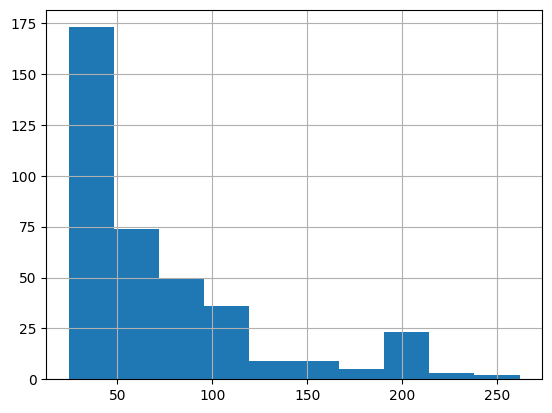

In [194]:
# for rows where Wingspan_ft_without_winglets_sharklets is missing, fill in the value from Wingspan_ft_with_winglets_sharklets
df.fillna({'Wingspan_ft_without_winglets_sharklets': df['Wingspan_ft_with_winglets_sharklets']}, inplace=True)
# for rows where Wingspan_ft_with_winglets_sharklets is missing, fill in the value from Wingspan_ft_without_winglets_sharklets
df.fillna({'Wingspan_ft_with_winglets_sharklets': df['Wingspan_ft_without_winglets_sharklets']}, inplace=True)
# make new column Wingspan_ft that is the average of the two
df['Wingspan_ft'] = (df['Wingspan_ft_without_winglets_sharklets'] + df['Wingspan_ft_with_winglets_sharklets'])/2
# drop the two original columns
df.drop(columns=['Wingspan_ft_without_winglets_sharklets','Wingspan_ft_with_winglets_sharklets'],axis=1,inplace=True)
print(df.shape)
num_cols = df.select_dtypes(include=['float64','int64']).columns
print(df[num_cols].isnull().sum())
df['Wingspan_ft'].hist()